In [24]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Data

In [25]:
import torchvision.datasets as data

CIFAR_train = data.CIFAR10('./', download=True, train=True)
CIFAR_test = data.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
X_train = torch.FloatTensor(CIFAR_train.data).permute(0, 3, 1, 2) / 255
y_train = torch.tensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data).permute(0, 3, 1, 2) / 255
y_test = torch.tensor(CIFAR_test.targets)

frog


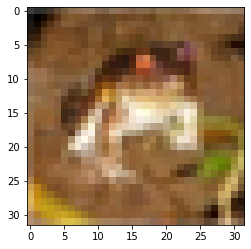

In [27]:
import matplotlib.pyplot as plt

print(CIFAR_train.classes[int(y_train[0])])
plt.imshow(X_train[0].permute(1, 2, 0))
plt.show()

In [28]:
class Dataset():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)

In [29]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(Dataset(X_train, y_train), 
                          batch_size = batch_size,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(Dataset(X_test, y_test), 
                          batch_size = batch_size,
                          shuffle=True,
                          num_workers=2)

# Train Functions

In [30]:
def train(net, train_loader, test_loader, nepoch=10):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), amsgrad=True, lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    loss_hist = {'test': [], 'train': []}
    accy_hist = {'test': [], 'train': []}

    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Test'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)

    for epoch in range(nepoch):
        for phase in ['train', 'test']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                net.train()
            else:
                dataloader = test_loader
                net.eval()
            
            epoch_loss = 0
            epoch_accy = 0

            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()
                preds = net(X_batch)
                loss_val = loss(preds, y_batch)
                
                if phase == 'train':
                    loss_val.backward()
                    optimizer.step()
                
                preds = preds.argmax(dim=1)

                epoch_loss += loss_val.item()
                epoch_accy += (preds == y_batch.data).float().mean().data.cpu().numpy()

            epoch_loss /= len(dataloader)
            epoch_accy /= len(dataloader)

            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, nepoch, epoch_loss, epoch_accy), end='')
            else:
                print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_accy))

            loss_hist[phase].append(epoch_loss)
            accy_hist[phase].append(epoch_accy)

    hist = {'loss': loss_hist, 'accy': accy_hist}
    print('-' * 50)
    return net, hist

In [31]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def report(net, stats, test_loader):
    net = net.cpu()
    test = []
    preds = []

    for X_batch, y_batch in test_loader:
        preds += list(net.forward(X_batch).argmax(dim=1).detach().numpy())
        test += list(y_batch.detach().numpy())
    
    report = classification_report(test, preds)
    print(report)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    
    ax1.plot(stats['accy']['train'], label='Train Accuracy')
    ax1.plot(stats['accy']['test'], label='Test Accuracy')
    ax1.legend()
    
    ax2.plot(stats['loss']['train'], label='Train Loss')
    ax2.plot(stats['loss']['test'], label='Test Loss')
    ax2.legend()

# Network

In [32]:
class CifarNet(torch.nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()

        self.bn0 = torch.nn.BatchNorm2d(num_features=3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.bn1 =  torch.nn.BatchNorm2d(num_features=64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.bn2 =  torch.nn.BatchNorm2d(num_features=128)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.bn3 =  torch.nn.BatchNorm2d(num_features=256)
        self.dp1 = torch.nn.Dropout2d(0.25)

        self.fc1 = torch.nn.Linear(8 * 8 * 256, 256)
        self.act4 = torch.nn.ReLU()
        self.bn4 =  torch.nn.BatchNorm1d(num_features=256)

        self.fc2 = torch.nn.Linear(256, 64)
        self.act5 = torch.nn.ReLU()
        self.bn5 =  torch.nn.BatchNorm1d(num_features=64)
        self.dp2 = torch.nn.Dropout(0.5)

        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.bn0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.dp1(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.bn4(x)

        x = self.fc2(x)
        x = self.act5(x)
        x = self.bn5(x)
        x = self.dp2(x)

        x = self.fc3(x)
        return x

# Results

       |       Train        |        Test        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 10|    1.2410    0.5665|    0.8539    0.7005|
  2/ 10|    0.8413    0.7171|    0.6999    0.7594|
  3/ 10|    0.6708    0.7745|    0.6511    0.7762|
  4/ 10|    0.5318    0.8218|    0.6110    0.7941|
  5/ 10|    0.4248    0.8596|    0.6035    0.7973|
  6/ 10|    0.3280    0.8904|    0.6342    0.7979|
  7/ 10|    0.1822    0.9428|    0.5634    0.8198|
  8/ 10|    0.1401    0.9582|    0.5636    0.8201|
  9/ 10|    0.1140    0.9667|    0.5757    0.8219|
 10/ 10|    0.0964    0.9736|    0.5818    0.8236|
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.90      0.92      0.91      1000
           2       0.75      0.75      0.75      1000
           3       0.65      0.69      0.67      1000
           4   

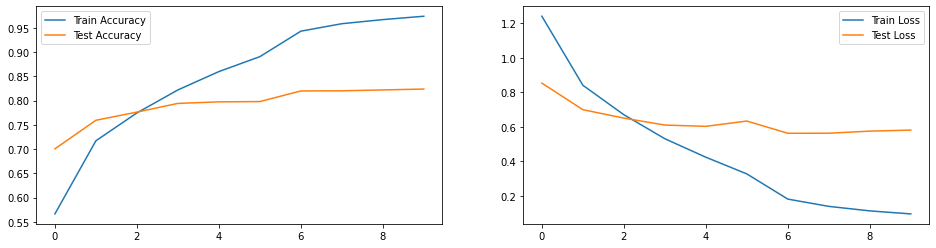

In [34]:
net, stats = train(CifarNet(), train_loader, test_loader, nepoch=10)
report(net, stats, test_loader)

In [35]:
torch.save(net, 'CifarNet.pth')